## Depth_pro
[GitHub repo](https://github.com/apple/ml-depth-pro/tree/main)

In [8]:
from depth_pro.depth_pro import DepthProConfig
import matplotlib.pyplot as plt
import depth_pro
import torch
import numpy as np
from PIL import Image
from vcd import core, scl, utils

import open3d as o3d

In [2]:
image_path  = "../data/input/test/images/CAM_FRONT_0.jpg"
vcd_path    = "../data/input/test/openlabel/openlabel.json"
model_path  = "../models/ml_depth_pro/depth_pro.pt"

DEFAULT_MONODEPTH_CONFIG_DICT = DepthProConfig(
    patch_encoder_preset="dinov2l16_384",
    image_encoder_preset="dinov2l16_384",
    checkpoint_uri=model_path,
    decoder_features=256,
    use_fov_head=True,
    fov_encoder_preset="dinov2l16_384",
)

device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
print(device)

cuda:4


In [3]:
# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms(config=DEFAULT_MONODEPTH_CONFIG_DICT, device=device)
model.eval()

/workspaces/bev2seg_2/ml-depth-pro/src/depth_pro/depth_pro.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(config.checkpoint_uri, map_location=

DepthPro(
  (encoder): DepthProEncoder(
    (patch_encoder): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linea

In [4]:
# Load and preprocess an image.
image, _, f_px = depth_pro.load_rgb(image_path)
image = transform(image)

# Run inference.
prediction = model.infer(image, f_px=f_px)
depth = prediction["depth"]  # Depth in [m].
focallength_px = prediction["focallength_px"]  # Focal length in pixels.

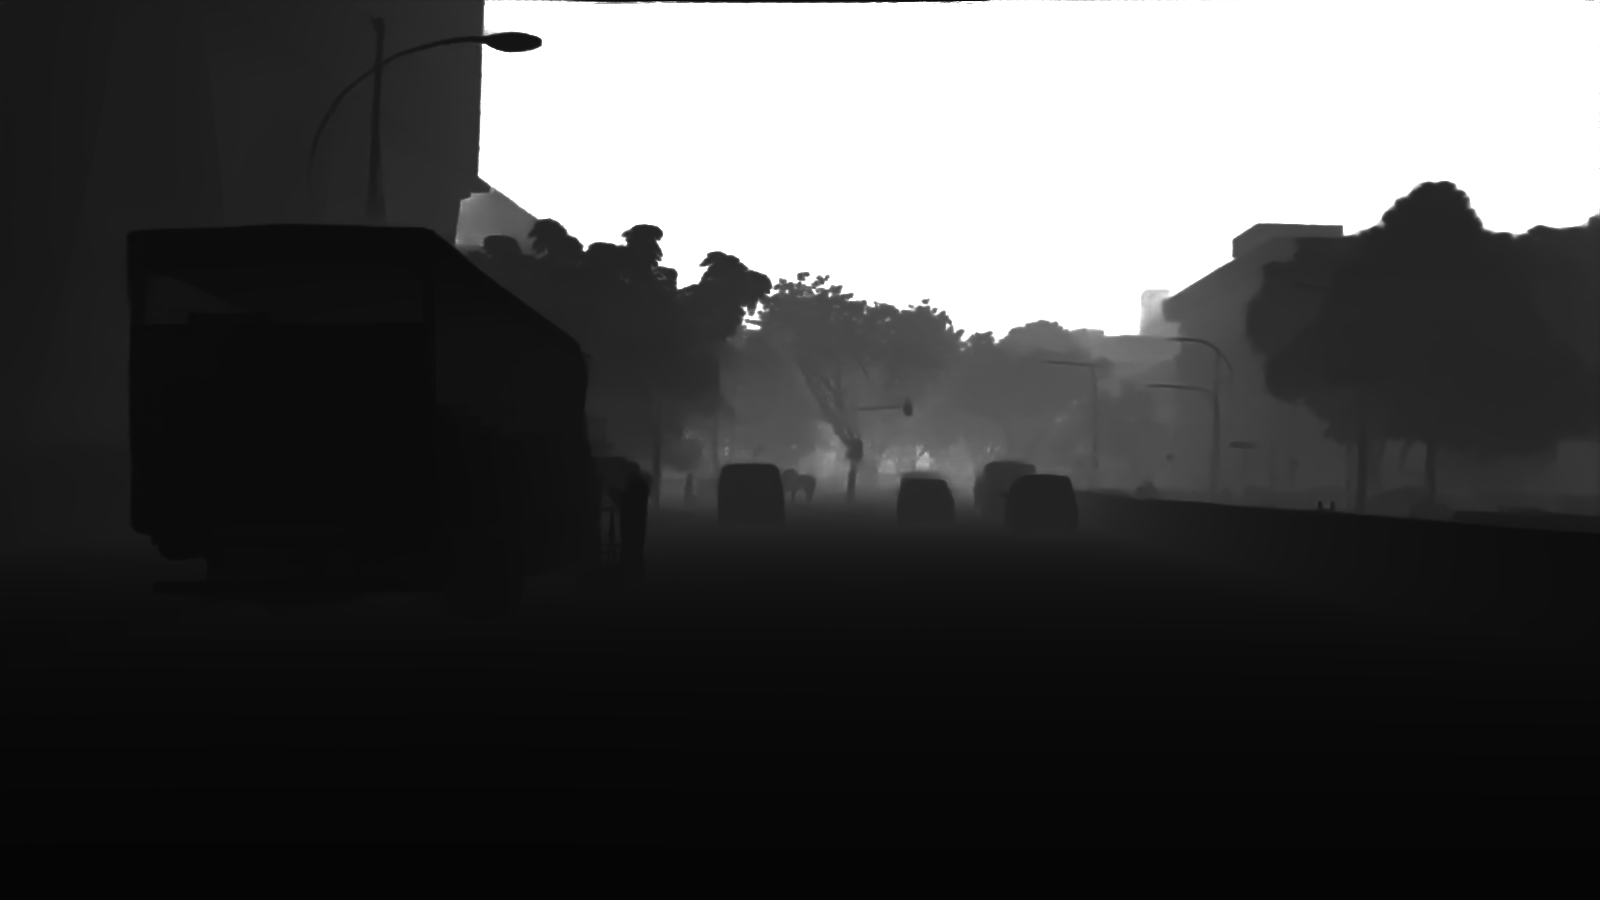

tensor(1382.6686, device='cuda:4')

In [ ]:
depth_image_np = depth.detach().cpu().numpy()
depth_image_pil = Image.fromarray(depth_image_np.astype(np.float32), mode='F')
depth_image_pil.show()
focallength_px

In [12]:
vcd = core.OpenLABEL()
vcd.load_from_file(vcd_path)
scene = scl.Scene(vcd)
camera = scene.get_camera("CAM_FRONT")

h, w = depth_image_np.shape
depth_pixel_values = depth_image_np.flatten()
print(f"depth image shape (H, W): {h, w}")

x_coords, y_coords  = np.meshgrid(np.arange(w), np.arange(h))
pixel_coords        = np.stack([y_coords.ravel(), x_coords.ravel()], axis=-1)
print(f"pixel_coords: {pixel_coords}")

cam_2d_coords_3xN = utils.add_homogeneous_row(pixel_coords.T)
print(f"cam_2d_coords_3xN: {cam_2d_coords_3xN}")

cam_2d_ray3d_3xN = camera.reproject_points2d(points2d_3xN=cam_2d_coords_3xN)
print(f"cam_2d_ray3d_3xN: {cam_2d_ray3d_3xN}")


xyz_3d_coords_3xN = cam_2d_ray3d_3xN * depth_pixel_values
print(f"xyz_3d_coords_3xN.shape: {xyz_3d_coords_3xN.shape} | xyz_3d_coords_3xN: {xyz_3d_coords_3xN}")


non_zero_depth_mask = xyz_3d_coords_3xN[:, 2] != 0
pcd_points  = xyz_3d_coords_3xN[non_zero_depth_mask]
pcd_points = pcd_points.T
print(f"non_zero_depth_mask.shape: {non_zero_depth_mask.shape} | non_zero_depth_mask: {non_zero_depth_mask}")
print(f"pcd_points.shape: {pcd_points.shape} | pcd_points: {pcd_points}")


point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(pcd_points)

depth image shape (H, W): (900, 1600)
pixel_coords: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [ 899 1597]
 [ 899 1598]
 [ 899 1599]]
cam_2d_coords_3xN: [[0.000e+00 0.000e+00 0.000e+00 ... 8.990e+02 8.990e+02 8.990e+02]
 [0.000e+00 1.000e+00 2.000e+00 ... 1.597e+03 1.598e+03 1.599e+03]
 [1.000e+00 1.000e+00 1.000e+00 ... 1.000e+00 1.000e+00 1.000e+00]]
cam_2d_ray3d_3xN: [[-0.64454827 -0.64454827 -0.64454827 ...  0.06532838  0.06532838
   0.06532838]
 [-0.38810833 -0.3873187  -0.38652907 ...  0.8729295   0.87371913
   0.87450876]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]]
xyz_3d_coords_3xN.shape: (3, 1440000) | xyz_3d_coords_3xN: [[ -5.80957636 -20.49289479 -14.462058   ...   0.34109663   0.34310512
    0.25895368]
 [ -3.49817861 -12.31448711  -8.67274973 ...   4.55779443   4.5887794
    3.46644553]
 [  9.01340771  31.79419708  22.43750954 ...   5.22126293   5.25200748
    3.96387744]]
non_zero_depth_mask.shape: (3,) | non_zero_depth_mask: [ True  True  

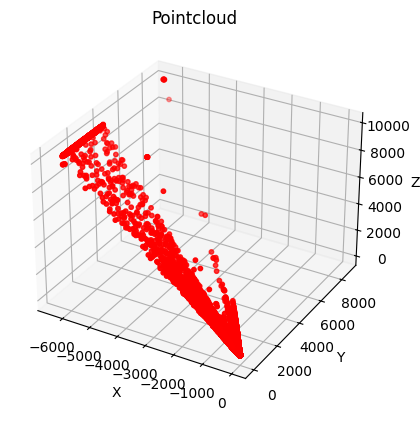

In [13]:
xyz = np.asarray(point_cloud.points)

# Crear una figura y un conjunto de ejes 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar la nube de puntos
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=10, c='r', marker='o')

# Etiquetas y título
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Pointcloud')

# Mostrar el gráfico
plt.show()